### Environment

- grid
  - $\{(x, y) : (x, y) \textrm{ is a start position, normal position, or finish position}\}$
- noise
  - probability of velocity increment being overridden to $(0, 0)$

### State

- position
  - $(x, y)$
- velocity
  - $(v_x, v_y)$

### Action

- velocity increment
  - $(\Delta v_x, \Delta v_y) \textrm{ such that } \Delta v_x, \Delta v_y \in \{-1, 0, 1\}$

### Reward

- $-1$ for each step

In [1]:
class TwoVector:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def copy(self):
        return self.__class__(self.x, self.y)

    def __add__(self, other):
        return self.__class__(self.x + other.x, self.y + other.y)
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __repr__(self):
        return f'{self.__class__.__name__}({self.x}, {self.y})'
    
    def __str__(self):
        return f'({self.x}, {self.y})'
    
    def __getitem__(self, index):
        if index == 0:
            return self.x
        elif index == 1:
            return self.y
        else:
            raise KeyError('Invalid index for 2-tuple')
            
    def __setitem__(self, index, value):
        if index == 0:
            self.x = value
        elif index == 1:
            self.y = value
        else:
            raise KeyError('Invalid index for 2-tuple')
            
    def __hash__(self):
        return hash((self.x, self.y))
    
    def __len__(self):
        return 2

In [2]:
import random

class Grid:
    def __init__(self, start_squares, normal_squares, finish_squares):
        self._start_squares = {TwoVector(square[0], square[1]) for square in start_squares}
        self._start_squares_tuple = tuple(self._start_squares)
        self._normal_squares = {TwoVector(square[0], square[1]) for square in normal_squares}
        self._finish_squares = {TwoVector(square[0], square[1]) for square in finish_squares}
        self._all_squares = set.union(self._start_squares, self._normal_squares, self._finish_squares)
        
    @property
    def start_squares(self):
        return self._start_squares
    
    @property
    def normal_squares(self):
        return self._normal_squares
    
    @property
    def finish_squares(self):
        return self._finish_squares
    
    @property
    def all_squares(self):
        return self._all_squares
    
    def __repr__(self):
        return f'{self.__class__.__name__}({repr(self.start_squares)}, {repr(self.normal_squares)}, {repr(self.finish_squares)})'
    
    def __str__(self):
        return f'start squares: {self.start_squares}, normal squares: {self.normal_squares}, finish squares: {self.finish_squares}'
    
    def __eq__(self, other):
        return self.start_squares == other.start_squares and self.normal_squares == other.normal_squares and self.finish_squares == other.finish_squares
    
    def __hash__(self):
        return hash(repr(self))
    
    def __len__(self):
        return len(self.all_squares)
    
    def copy(self):
        return self.__class__(self.start_squares.copy(), self.normal_squares.copy(), self.finish_squares.copy())

    def isStartSquare(self, square):
        return square in self.start_squares
        
    def isWithinBoundary(self, square):
        return square in self.all_squares
        
    def isFinishSquare(self, square):
        return square in self.finish_squares

    def getRandomStartSquare(self):
        return random.choice(self._start_squares_tuple)

In [3]:
def get_grid_extrema(grid):
    min_x = min(map(lambda square: square.x, grid.all_squares))
    min_y = min(map(lambda square: square.y, grid.all_squares))
    max_x = max(map(lambda square: square.x, grid.all_squares))
    max_y = max(map(lambda square: square.y, grid.all_squares))
    return (min_x, min_y), (max_x, max_y)

In [4]:
def draw_ascii_grid(grid):
    (min_x, min_y), (max_x, max_y) = get_grid_extrema(grid)
    for y in range(max_y, min_y - 1, -1):
        for x in range(min_x, max_x + 1):
            if TwoVector(x, y) in grid.start_squares:
                print('S', end='')
            elif TwoVector(x, y) in grid.normal_squares:
                print('X', end='')
            elif TwoVector(x, y) in grid.finish_squares:
                print('F', end='')
            else:
                print(' ', end='')
        print()

In [5]:
import matplotlib.pyplot as plt

def plot_grid(grid):
    for square in grid.all_squares:
        if grid.isStartSquare(square):
            fill_color = 'red'
        elif grid.isFinishSquare(square):
            fill_color = 'green'
        else:
            fill_color = 'white'
        plt.gca().add_patch(plt.Rectangle((square.x - 0.5, square.y - 0.5), 1, 1, fc=fill_color, ec='black'))
    (min_x, min_y), (max_x, max_y) = get_grid_extrema(grid)
    mid_x = (min_x + max_x) / 2.0
    mid_y = (min_y + max_y) / 2.0
    half_max_range = (max(max_x - min_x, max_y - min_y) + 1) / 2.0
    plt.xlim(mid_x - half_max_range, mid_x + half_max_range)
    plt.ylim(mid_y - half_max_range, mid_y + half_max_range)

In [6]:
import math

class State:
    valid_velocity_increments = (0, -1, 1)
    terminal_position = TwoVector(float('nan'), float('nan'))
    terminal_velocity = TwoVector(float('nan'), float('nan'))
    
    def __init__(self, position, velocity):
        self._position = TwoVector(position[0], position[1])
        self._velocity = TwoVector(velocity[0], velocity[1])
        
    def __repr__(self):
        return f'{self.__class__.__name__}({repr(self.position)}, {repr(self.velocity)})'
    
    def __str__(self):
        return f'position: {self.position}, velocity: {self.velocity}'
    
    def __eq__(self, other):
        return self.position == other.position and self.velocity == other.velocity
    
    def __hash__(self):
        return hash((self.position, self.velocity))
    
    @property
    def position(self):
        return self._position
    
    @property
    def velocity(self):
        return self._velocity
        
    def isValidAction(self, action):
        if self.isTerminal():
            return False
        if action.velocity_increment.x not in self.__class__.valid_velocity_increments:
            return False
        if action.velocity_increment.y not in self.__class__.valid_velocity_increments:
            return False
        resultant_velocity = self.velocity + action.velocity_increment
        if not 0 <= resultant_velocity.x < 5:
            return False
        if not 0 <= resultant_velocity.y < 5:
            return False
        if resultant_velocity.x == 0 and resultant_velocity.y == 0:
            return False
        return True
    
    def getPossibleActions(self):
        possible_actions = []
        for horizontal_velocity_increment in self.__class__.valid_velocity_increments:
            for vertical_velocity_increment in self.__class__.valid_velocity_increments:
                action = Action(horizontal_velocity_increment, vertical_velocity_increment)
                if self.isValidAction(action):
                    possible_actions.append(action)
        return possible_actions
    
    def isTerminal(self):
        return math.isnan(self.position.x) and math.isnan(self.position.y) and math.isnan(self.velocity.x) and math.isnan(self.velocity.y)

In [7]:
class Action:
    def __init__(self, horizontal_velocity_increment, vertical_velocity_increment):
        self._velocity_increment = TwoVector(horizontal_velocity_increment, vertical_velocity_increment)

    @property
    def velocity_increment(self):
        return self._velocity_increment
    
    def __eq__(self, other):
        return self.velocity_increment == other.velocity_increment
    
    def __hash__(self):
        return hash(self.velocity_increment)
    
    def __repr__(self):
        return f'{self.__class__.__name__}({repr(self.velocity_increment)})'
    
    def __str__(self):
        return f'velocity increment: {self.velocity_increment}'

In [8]:
import random

class Environment:
    def __init__(self, grid, noise):
        self.grid = grid
        self.noise = noise

    def getInitialState(self, starting_position=None):
        if starting_position is None:
            starting_position = self.grid.getRandomStartSquare()
        return State(starting_position, TwoVector(0, 0))
        
    def simulateAction(self, input_state, action):
        if not input_state.isValidAction(action):
            raise ValueError('Attempting invalid action')
        actual_velocity_increment = action.velocity_increment
        if self.noise > 0 and random.random() < self.noise:
            actual_velocity_increment = TwoVector(0, 0)
        resultant_velocity = input_state.velocity + actual_velocity_increment
        squares_left_to_move = resultant_velocity.copy()
        new_position = input_state.position.copy()
        new_velocity = resultant_velocity
        while squares_left_to_move.x > 0 or squares_left_to_move.y > 0:
            if squares_left_to_move.x > squares_left_to_move.y:
                new_position.x += 1
                squares_left_to_move.x -= 1
            elif squares_left_to_move.x < squares_left_to_move.y:
                new_position.y += 1
                squares_left_to_move.y -= 1
            else:
                new_position.x += 1
                new_position.y += 1
                squares_left_to_move.x -= 1
                squares_left_to_move.y -= 1
            if self.grid.isFinishSquare(new_position):
                new_position = State.terminal_position
                new_velocity = State.terminal_velocity
                break
            elif not self.grid.isWithinBoundary(new_position):
                new_position = self.grid.getRandomStartSquare()
                new_velocity = TwoVector(0, 0)
                break
        output_state = State(new_position, new_velocity)
        reward = -1
        return output_state, reward

In [9]:
import random

class EpsilonSoftPolicy:
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon

    def getActionAndImportanceSamplingRatio(self, state):
        possible_actions = state.getPossibleActions()
        if len(possible_actions) == 0:
            raise ValueError('State has no possible actions')  
        if state not in self.Q or len(self.Q[state]) == 0:
            greedy_action = possible_actions[0]
        else:
            greedy_action = max(self.Q[state], key=self.Q[state].get)
        if self.epsilon == 0:
            action = greedy_action
            importance_sampling_ratio = 1
        else:
            minimum_probability = self.epsilon / len(possible_actions)
            random_draw = random.random()
            if random_draw < self.epsilon:
                action = possible_actions[int(random_draw // minimum_probability)]
            else:
                action = greedy_action
            if action == greedy_action:
                importance_sampling_ratio = 1.0 / (1 - self.epsilon + minimum_probability)
            else:
                importance_sampling_ratio = 1.0 / minimum_probability
        return action, importance_sampling_ratio

In [10]:
class GreedyPolicy(EpsilonSoftPolicy):
    def __init__(self, Q):
        super().__init__(Q, 0)
        
    def getAction(self, state):
        return super().getActionAndImportanceSamplingRatio(state)[0]

In [11]:
def generate_episode(environment, policy, starting_position=None):
    states = []
    actions = []
    rewards = []
    importance_sampling_ratios = []
    states.append(environment.getInitialState(starting_position))
    while not states[-1].isTerminal():
        action, importance_sampling_ratio = policy.getActionAndImportanceSamplingRatio(states[-1])
        actions.append(action)
        next_state, next_reward = environment.simulateAction(states[-1], actions[-1])
        states.append(next_state)
        rewards.append(next_reward)
        importance_sampling_ratios.append(importance_sampling_ratio)
    return states, actions, rewards, importance_sampling_ratios

In [12]:
class OffPolicyMCControlMethod:
    def __init__(self, grid, gamma=1, noise=0.1):
        self._grid = grid
        self._gamma = gamma
        self._noise = noise
        self._Q = {}
        self._C = {}
    
    @property
    def grid(self):
        return self._grid
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def noise(self):
        return self._noise
    
    @property
    def Q(self):
        return self._Q
    
    def run(self, n_episodes, epsilon):
        environment = Environment(self.grid, self.noise)
        for _ in range(n_episodes):
            b = EpsilonSoftPolicy(self.Q, epsilon)
            states, actions, rewards, importance_sampling_ratios = generate_episode(environment, b)
            G = 0
            W = 1
            for state, action, reward, importance_sampling_ratio in zip(reversed(states[:-1]), reversed(actions), reversed(rewards), reversed(importance_sampling_ratios)):
                G = self.gamma * G + reward
                if state not in self._C:
                    self._C[state] = {}
                if action not in self._C[state]:
                    self._C[state][action] = 0
                self._C[state][action] += W
                if state not in self.Q:
                    self._Q[state] = {}
                if action not in self.Q[state]:
                    self._Q[state][action] = 0
                self._Q[state][action] += W / self._C[state][action] * (G - self.Q[state][action])
                if GreedyPolicy(self.Q).getAction(state) != action:
                    break
                W *= importance_sampling_ratio

In [13]:
import matplotlib.pyplot as plt

def plot_episode(states, actions, color=None):
    for state, action in zip(states, actions):
        plt.arrow(state.position.x, state.position.y,
                  state.velocity.x + action.velocity_increment.x, state.velocity.y + action.velocity_increment.y,
                  fc=color,
                  width=0.2,
                  length_includes_head=True)

In [14]:
def plot_all_starts(grid, policy):
    environment = Environment(grid, 0)
    for start_square in grid.start_squares:
        states, actions, _, _ = generate_episode(environment, policy, start_square)
        plot_episode(states, actions)

In [15]:
grid_1 = Grid([[i, 0] for i in range(3, 9)],
              ([[0, j] for j in range(18, 28)]
               + [[1, j] for j in range(10, 29)]
               + [[2, j] for j in range(3, 31)]
               + [[i, j] for i in range(3, 9) for j in range(1, 32)]
               + [[9, j] for j in range(25, 32)]
               + [[i, j] for i in range(10, 16) for j in range(26, 32)]),
              [[16, j] for j in range(26, 32)])

In [16]:
%%time
mc_1 = OffPolicyMCControlMethod(grid_1)
mc_1.run(1_000_000, 0.1)

CPU times: user 37min 45s, sys: 300 ms, total: 37min 45s
Wall time: 37min 50s


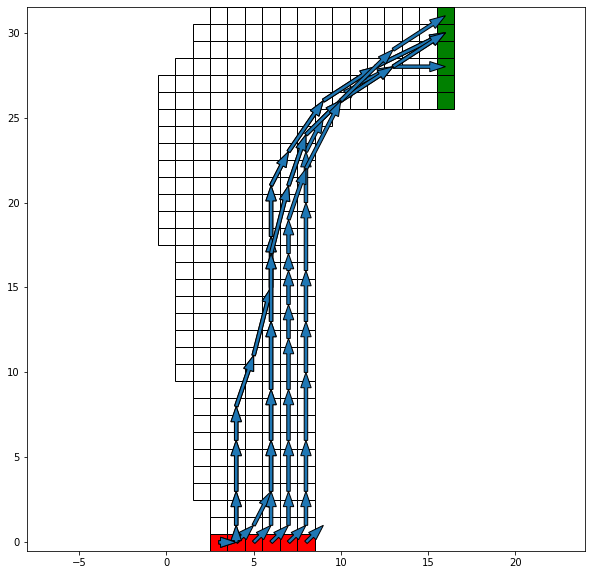

In [17]:
plt.figure(figsize=(10, 10))
plot_grid(grid_1)
plot_all_starts(grid_1, GreedyPolicy(mc_1.Q))
plt.show()

In [18]:
grid_2 = Grid([[i, 0] for i in range(0, 23)],
              ([[0, j] for j in range(1, 3)]
               + [[1, j] for j in range(1, 4)]
               + [[2, j] for j in range(1, 5)]
               + [[3, j] for j in range(1, 6)]
               + [[4, j] for j in range(1, 7)]
               + [[5, j] for j in range(1, 8)]
               + [[6, j] for j in range(1, 9)]
               + [[7, j] for j in range(1, 10)]
               + [[8, j] for j in range(1, 11)]
               + [[9, j] for j in range(1, 12)]
               + [[10, j] for j in range(1, 13)]
               + [[11, j] for j in range(1, 14)]
               + [[11, j] for j in range(23, 27)]
               + [[12, j] for j in range(1, 15)]
               + [[12, j] for j in range(22, 28)]
               + [[13, j] for j in range(1, 16)]
               + [[13, j] for j in range(21, 29)]
               + [[i, j] for i in range(14, 16) for j in range(1, 29)]
               + [[i, j] for i in range(16, 23) for j in range(1, 30)]
               + [[23, j] for j in range(17, 30)]
               + [[i, j] for i in range(24, 26) for j in range(18, 30)]
               + [[26, j] for j in range(19, 30)]
               + [[i, j] for i in range(27, 30) for j in range(20, 30)]
               + [[30, j] for j in range(21, 30)]),
              [[31, j] for j in range(21, 30)])

In [19]:
%%time
mc_2 = OffPolicyMCControlMethod(grid_2)
mc_2.run(1_000_000, 0.1)

CPU times: user 27min 12s, sys: 225 ms, total: 27min 12s
Wall time: 27min 16s


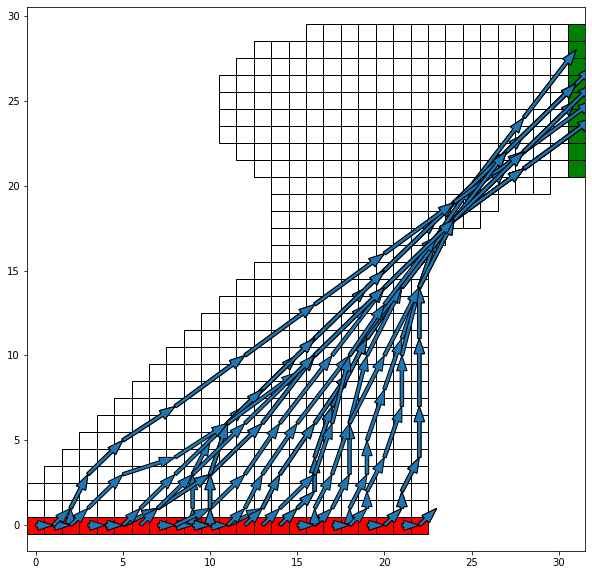

In [20]:
plt.figure(figsize=(10, 10))
plot_grid(grid_2)
plot_all_starts(grid_2, GreedyPolicy(mc_2.Q))
plt.show()